# Library

In [ ]:
!pip install -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 1.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import random
import keras_tuner as kt
from skimage.util import img_as_float
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage.util import img_as_ubyte
from skimage.transform import rotate, AffineTransform, warp
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing import image as keras_image

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import InputLayer, Conv2D,  MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam

# load  Data

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aseprohman","key":"7d60f7b4295125ef81ebf08eec8fc5ce"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download kaggle dataset and unzip the file

!kaggle datasets download -d lara311/flowers-five-classes
!unzip flowers-five-classes

In [ ]:
# membuat foler baru dan memindakannya agar terlihat rapi
source_path = '/content/train'          # folder asal
base_path = '/content/flowers'
target_path = os.path.join(base_path, 'type_flowers')

# folder tujuan
os.makedirs(target_path, exist_ok=True)

# Pindahkan SEMUA isi folder train ke type_flowers
for item in os.listdir(source_path):
    item_path = os.path.join(source_path, item)

    if os.path.isdir(item_path):
        shutil.move(item_path, os.path.join(target_path, item))

# Hapus folder lama
shutil.rmtree('/content/train')

# Data Checking

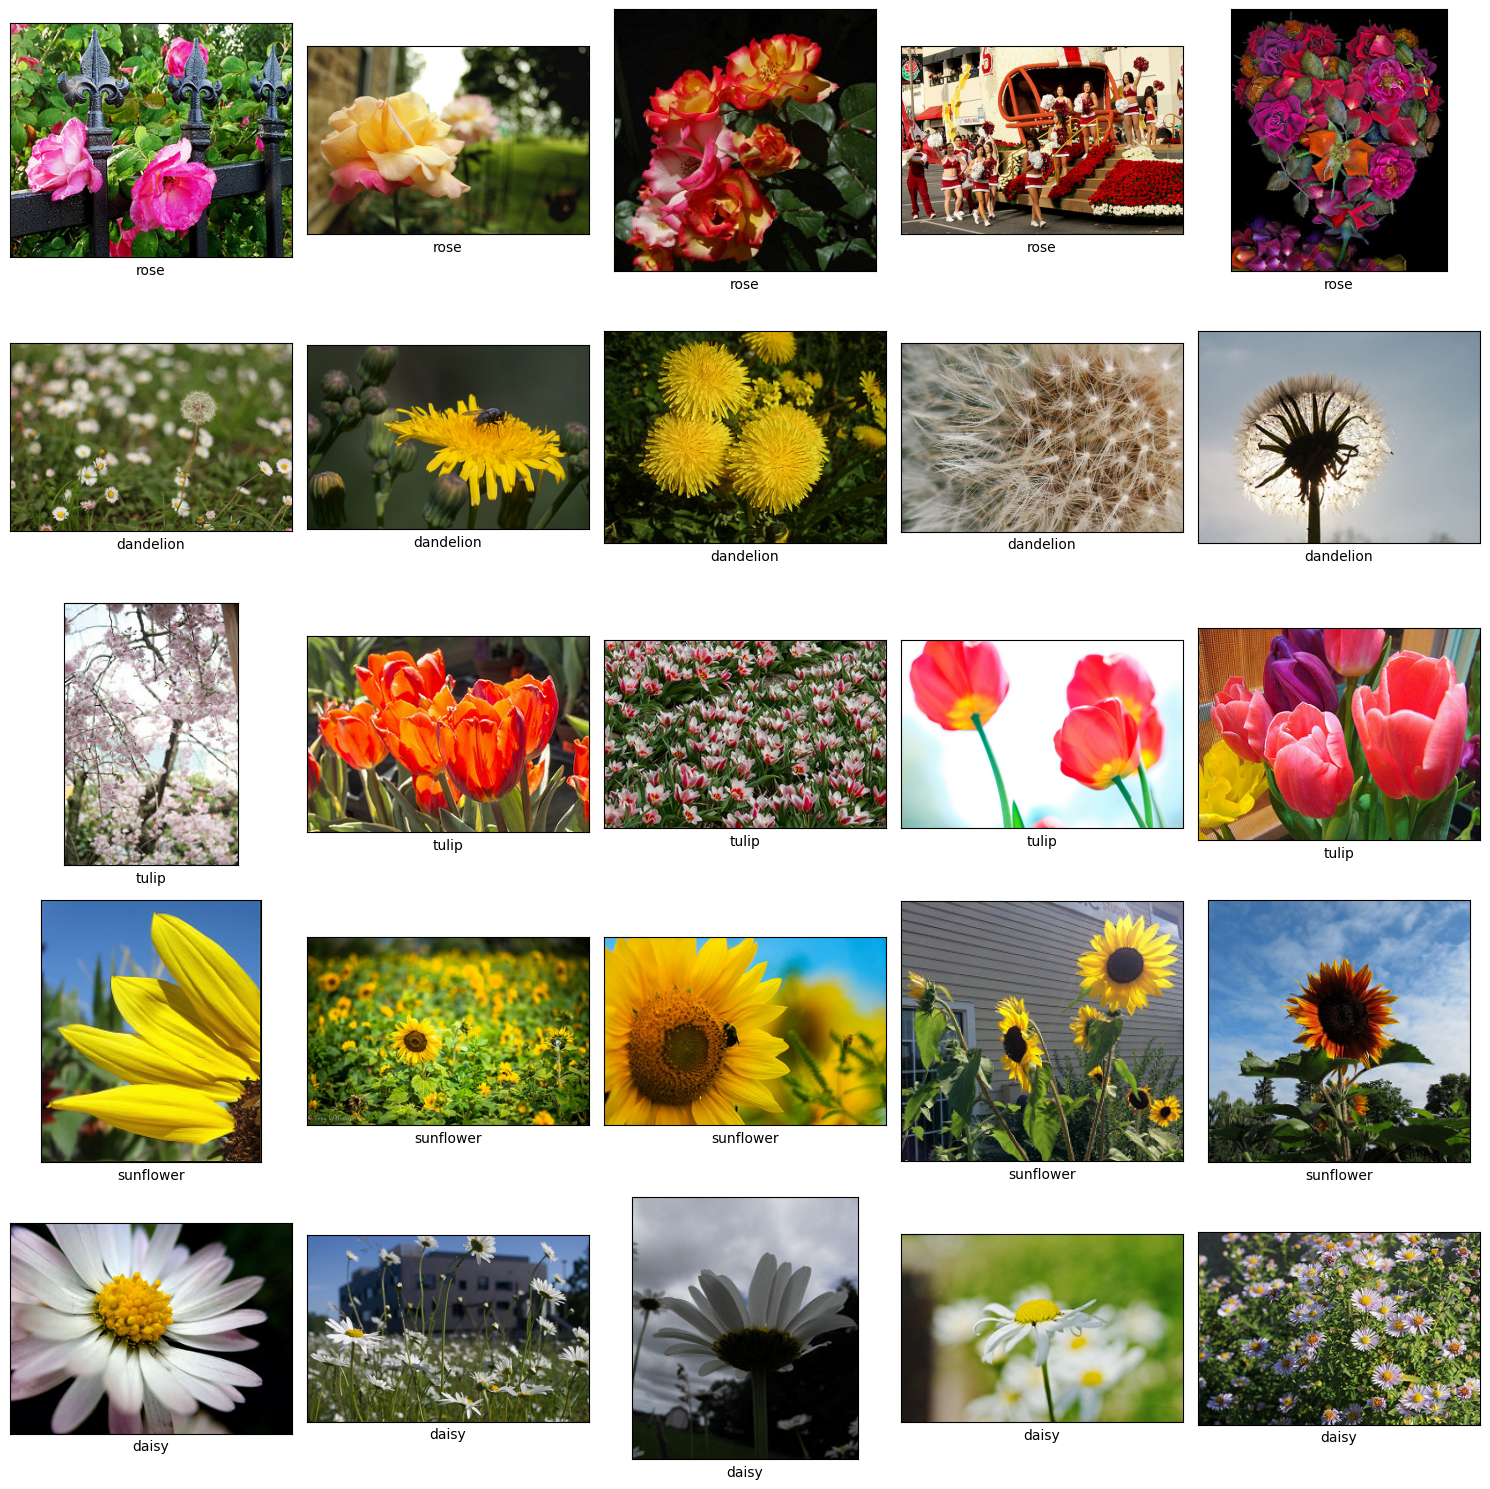

In [ ]:
character_image = {}
path = "/content/flowers/type_flowers"
# Isi dictionary dengan gambar-gambar di setiap folder
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        character_image[class_name] = os.listdir(class_path)

# Memeriksa apakah dictionary telah terisi
if character_image:
    fig, axs = plt.subplots(len(character_image.keys()), 5, figsize=(15, 15))

    for i, class_name in enumerate(character_image.keys()):
        # Pilih 5 gambar acak dari setiap kelas
        images = np.random.choice(character_image[class_name], 5, replace=False)

        for j, image_name in enumerate(images):
            img_path = os.path.join(path, class_name, image_name)
            img = Image.open(img_path)
            axs[i, j].imshow(img)
            axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

    fig.tight_layout()
else:
    print("Gambar tidak tersedia")

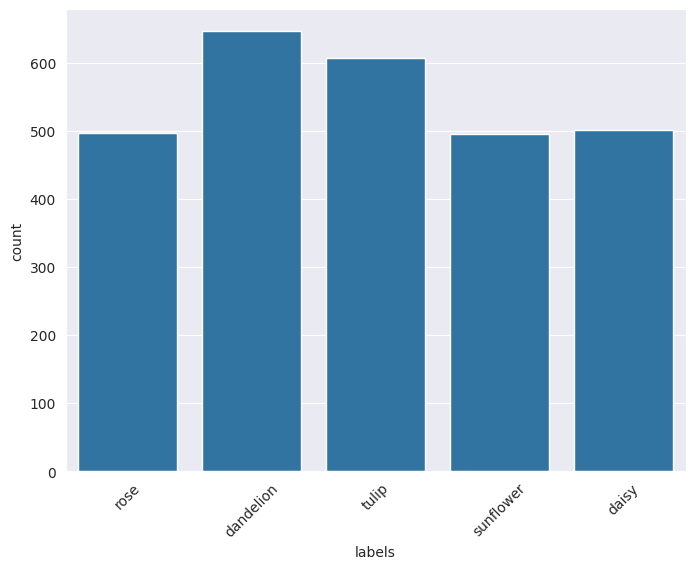

In [ ]:
# Buat daftar nama untuk setiap file
file_name = []
label = []
full_path = []
base_path = "/content/flowers/type_flowers"
# Telusuri file dari berbagai folder nya
for root, subdirs, files in os.walk(base_path):
    for name in files:
        full_path.append(os.path.join(root, name))
        label.append(root.split('/')[-1])
        file_name.append(name)

label_character = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": label
})
# Plot distribusi gambar di setiap kelas
plt.figure(figsize=(8,6))
sns.set_style("darkgrid")
sns.countplot(data=label_character, x='labels')
plt.xticks(rotation=45)
plt.show()

#  Split Data

In [ ]:
# Mengetahui label dan jumlah nya
data_path = "/content/flowers/type_flowers"
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(data_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)
# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
daisy        501
dandelion    646
rose         497
sunflower    495
tulip        607
dtype: int64

In [ ]:
# Split Data
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# masukan trainn dan test ke dalam masing-masng dataframe
df_train = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_test = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

#  Augmentasi Data

In [ ]:
# Buat folder untk simpan hasil train dan untukk prroses augmentasi
train_folder = "/content/flowers/train_from_df"
os.makedirs(train_folder, exist_ok=True)

for idx, row in df_train.iterrows():
    label = row['labels']
    src = row['path']
    dst_folder = os.path.join(train_folder, label)
    os.makedirs(dst_folder, exist_ok=True)

    dst = os.path.join(dst_folder, os.path.basename(src))
    shutil.copy(src, dst)

In [ ]:
# Buat Folder untuk simpan hasil augmentaasi
augmented_dir = "/content/flowers/train_augmented"
os.makedirs(augmented_dir, exist_ok=True)

In [ ]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img_as_float(img)
    angle = random.randint(0, 180)
    rotated = rotate(img, angle)
    return img_as_ubyte(rotated)

def clockwise_rotation(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img_as_float(img)
    angle = random.randint(0, 180)
    rotated = rotate(img, -angle)
    return img_as_ubyte(rotated)



# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def adjust_gamma(image, gamma=1.0, gain=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 * gain for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img_as_float(img)
    transform = AffineTransform(shear=0.2)
    sheared_img = warp(img, transform, mode="wrap")
    return img_as_ubyte(sheared_img)

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img_as_float(img)
    transform = AffineTransform(translation=(0, 40))
    warped = warp(img, transform, mode="wrap")
    return img_as_ubyte(warped)

# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : adjust_gamma,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

In [ ]:
# path gambar pada train
images_path = "/content/flowers/train_from_df"
# path gambar yang sudah di augmentasi
augmented_path = "/content/flowers/train_augmented"

# Proses Augmentasi
images_to_generate_per_class = 1000

for class_folder in os.listdir(images_path):
    class_folder_path = os.path.join(images_path, class_folder)

    if not os.path.isdir(class_folder_path) or class_folder == 'augmented':
        continue

    print(f"\nMemproses folder: {class_folder}")
    # Buat folder
    target_class_folder = os.path.join(augmented_path, class_folder)
    os.makedirs(target_class_folder, exist_ok=True)

    # Simpan gambar ke folder augmented
    for img_name in os.listdir(class_folder_path):
        if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            src = os.path.join(class_folder_path, img_name)
            dst = os.path.join(target_class_folder, img_name)
            shutil.copy(src, dst)
    images = [
        os.path.join(class_folder_path, img)
        for img in os.listdir(class_folder_path)
        if img.lower().endswith(('.jpg', '.png', '.jpeg'))
    ]

    if not images:
        print(f"    Tidak ada gambar di {class_folder}, skip.")
        continue

    i = 0
    while i < images_to_generate_per_class:
        image_path = random.choice(images)
        image = cv2.imread(image_path)

        if image is None:
            print(f"    Gagal baca gambar {image_path}, skip.")
            continue

        # Transformasi random
        transform_name = random.choice(list(transformations.keys()))
        transform_function = transformations[transform_name]
        transformed_image = transform_function(image)

        new_file_name = f"{class_folder}_aug_{i}_{transform_name}.jpg"
        save_path = os.path.join(target_class_folder, new_file_name)
        cv2.imwrite(save_path, transformed_image)

        i += 1

    print(f"    Berhasil augmentasi {i} gambar untuk {class_folder}")

print("\nSelesai augmentasi dan penggabungan semua folder!")


Memproses folder: rose
    Berhasil augmentasi 1000 gambar untuk rose

Memproses folder: dandelion
    Berhasil augmentasi 1000 gambar untuk dandelion

Memproses folder: tulip
    Berhasil augmentasi 1000 gambar untuk tulip

Memproses folder: sunflower
    Berhasil augmentasi 1000 gambar untuk sunflower

Memproses folder: daisy
    Berhasil augmentasi 1000 gambar untuk daisy

Selesai augmentasi dan penggabungan semua folder!


# Path untuk data train dan test

In [ ]:
#path data train hasil augmentasi
augmented_path = '/content/flowers/train_augmented'

data = []

# Loop semua subfolder
for label in os.listdir(augmented_path):
    label_path = os.path.join(augmented_path, label)

    if not os.path.isdir(label_path):
        continue

    # Loop semua file gambar dalam folder class
    for img_file in os.listdir(label_path):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path = os.path.join(label_path, img_file)
            data.append({
                'path': full_path,
                'labels': label,
                'set': 'train'
            })

# Buat DataFrame
df_train_augmented = pd.DataFrame(data)
df_train_augmented

path labels    set
0     /content/flowers/train_augmented/rose/rose_aug...   rose  train
1     /content/flowers/train_augmented/rose/14970973...   rose  train
2     /content/flowers/train_augmented/rose/rose_aug...   rose  train
3     /content/flowers/train_augmented/rose/rose_aug...   rose  train
4     /content/flowers/train_augmented/rose/21346056...   rose  train
...                                                 ...    ...    ...
7191  /content/flowers/train_augmented/daisy/daisy_a...  daisy  train
7192  /content/flowers/train_augmented/daisy/1724939...  daisy  train
7193  /content/flowers/train_augmented/daisy/4278442...  daisy  train
7194  /content/flowers/train_augmented/daisy/daisy_a...  daisy  train
7195  /content/flowers/train_augmented/daisy/daisy_a...  daisy  train

[7196 rows x 3 columns]

In [ ]:
# Gabungkan datframe trai dan test
df_all = pd.concat([df_train_augmented, df_test], ignore_index=True)
# melihat nilai pada setiap label
print(df_all.groupby(['set', 'labels']).size(), '\n')

set    labels   
test   daisy          92
       dandelion     119
       rose          109
       sunflower     106
       tulip         124
train  daisy        1409
       dandelion    1527
       rose         1388
       sunflower    1389
       tulip        1483
dtype: int64 



In [ ]:
# Simpan ke df dan dataset baru
base_path = "/content/flowers/flowers_final"

# Buat folder utama
os.makedirs(base_path, exist_ok=True)

# Loop semua baris di df_all
for idx, row in df_all.iterrows():
    label = row['labels']
    split = row['set']  # 'train' atau 'test'
    image_path = row['path']

    # Buat path tujuan
    dest_dir = os.path.join(base_path, split, label)
    os.makedirs(dest_dir, exist_ok=True)

    # Nama file (ambil nama file saja, bukan path lengkap)
    file_name = os.path.basename(image_path)
    dest_path = os.path.join(dest_dir, file_name)

    # Salin file ke folder tujuan
    shutil.copy(image_path, dest_path)

print("Semua data berhasil dipindah ke folder 'flowers_final'.")

Semua data berhasil dipindah ke folder 'flowers_final'.


# Normalisasi

In [ ]:
# Inisialisasi data train dan test
train_data = "/content/flowers/flowers_final/train"
test_data = "/content/flowers/flowers_final/test"

In [ ]:
# menyiapkan data gambar supaya siap, stabil, dan rapi sebelum dilatih ke model
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
# untuk data training
train_generator = datagen.flow_from_directory(train_data,
                                              batch_size=32,
                                              target_size=(150, 150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)
# untuk data validasi dipakai untuk mengevaluasi performa model saat training
validation_generator = datagen.flow_from_directory(train_data,
                                                   batch_size=32,
                                                   target_size=(150, 150),
                                                color_mode="rgb",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)
# untuk data testing mengambil gambar dari folder test_data, satu per satu (batch_size=1), tanpa augmentasi, untuk evaluasi akhir model
test_generator = test_datagen.flow_from_directory(test_data,
                                                  batch_size=1,
                                                  target_size=(150, 150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 6480 images belonging to 5 classes.
Found 716 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


# Modeling

In [ ]:
# Convolutional Neural Network (CNN) dengan Transfer Learning menggunakan MobileNetV2.

# Memuat model MobileNetV2 pretrained sebagai feature extractor dan mengunci bobotnya.
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(150,150,3))
base_model.trainable = False

# Membangun model klasifikasi lengkap dengan Transfer Learning.
model_1 = Sequential([
    Input(shape=(150, 150, 3)),base_model,
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    # Global Average Pooling dan FC layer
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,629,093 (10.03 MB)

 Trainable params: 371,109 (1.42 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Menghentikan training otomatis jika performa validasi tidak membaik.
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
# Menyimpan model terbaik selama training.
model_ckpt = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
callbacks = [early_stop, model_ckpt]

# melatih model
train_model = model_1.fit(train_generator,
          epochs=20,
          validation_data=validation_generator,
          callbacks=callbacks)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.5217 - loss: 1.2157
Epoch 1: val_loss improved from inf to 0.46356, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 165s 779ms/step - accuracy: 0.5223 - loss: 1.2143 - val_accuracy: 0.8198 - val_loss: 0.4636
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.8154 - loss: 0.5125
Epoch 2: val_loss improved from 0.46356 to 0.39144, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 154s 757ms/step - accuracy: 0.8154 - loss: 0.5124 - val_accuracy: 0.8575 - val_loss: 0.3914
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.8835 - loss: 0.3316
Epoch 3: val_loss improved from 0.39144 to 0.32774, saving model to best_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 158s 778ms/step - accuracy: 0.8835 - loss: 0.3315 - val_accuracy: 0.8827 - val_loss: 0.3277
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9248 - loss: 0.2141
Epoch 4: val_loss did not improve from 0.32774
203/203 ━━━━━━━━━━━━━━━━━━━━ 158s 777ms/step - accuracy: 0.9249 - loss: 0.2141 - val_accuracy: 0.8841 - val_loss: 0.3316
Epoch 5/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.9487 - loss: 0.1609
Epoch 5: val_loss did not improve from 0.32774
203/203 ━━━━━━━━━━━━━━━━━━━━ 157s 772ms/step - accuracy: 0.9487 - loss: 0.1609 - val_accuracy: 0.8966 - val_loss: 0.4217
Epoch 6/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9620 - loss: 0.1166
Epoch 6: val_loss did not improve from 0.32774
203/203 ━━━━━━━━━━━━━━━━━━━━ 155s 764ms/step - accuracy: 0.9620 - loss: 0.1166 - val_accuracy: 0.8994 - val_loss: 0.3926
Epoch 7/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.9602 - loss: 0.1189
Epoch 7: val_loss did n

# Evaluasi

In [ ]:
# Evaluasi model
results = model_1.evaluate(test_generator, return_dict=True)
print("\nHasil Evaluasi pada Data Test:")
print("==================================")
print(f"Loss: {results['loss']:.4f}")
print(f"Akurasi: {results['accuracy']*100:.2f}%")

550/550 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.8371 - loss: 0.5102

Hasil Evaluasi pada Data Test:
Loss: 0.5870
Akurasi: 81.64%


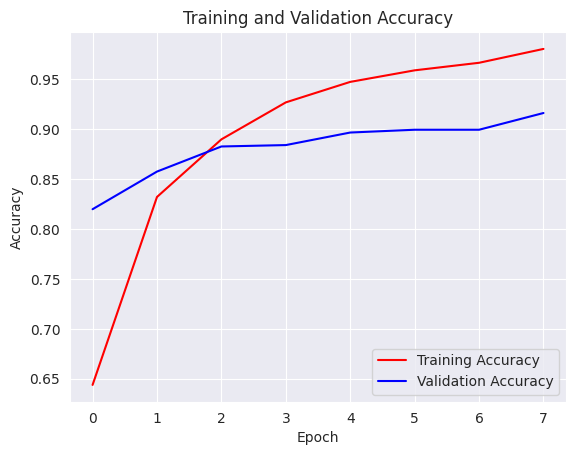

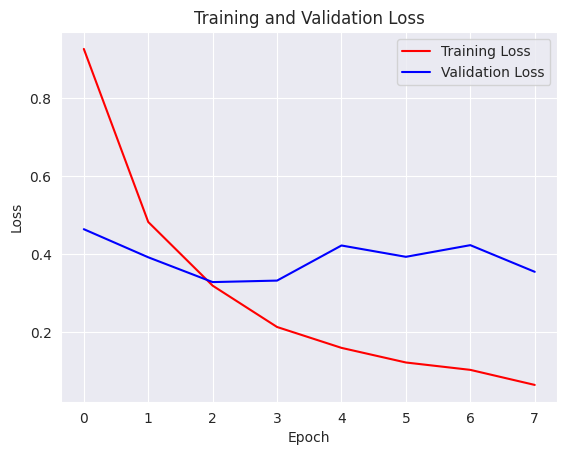

In [ ]:
acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']
loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs = range(len(acc))

# untuk akurasi
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Untuk loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


# Deployment

In [ ]:
from google.colab import files

uploaded = files.upload()

img_path = list(uploaded.keys())[0]

Saving download (1).jpg to download (1).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


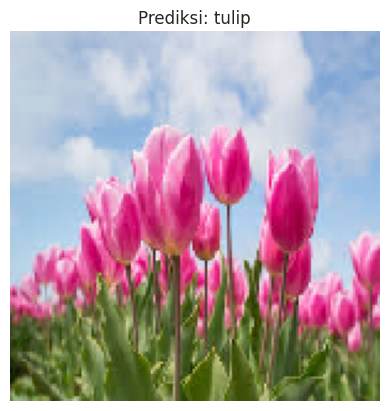

Probabilitas tiap kelas:
daisy: 0.01%
dandelion: 0.00%
rose: 0.41%
sunflower: 0.03%
tulip: 99.55%


In [ ]:
# Load & preprocessing
img = keras_image.load_img(img_path, target_size=(150,150))
img_array = keras_image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Prediksi
pred = model_1.predict(img_array)
pred_class = np.argmax(pred)

# Ambil nama kelas
class_names = list(train_generator.class_indices.keys())

# Tampilkan hasil
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediksi: {class_names[pred_class]}")
plt.show()

print("Probabilitas tiap kelas:")
for i, cls in enumerate(class_names):
    print(f"{cls}: {pred[0][i]*100:.2f}%")

Saving download.jpg to download.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


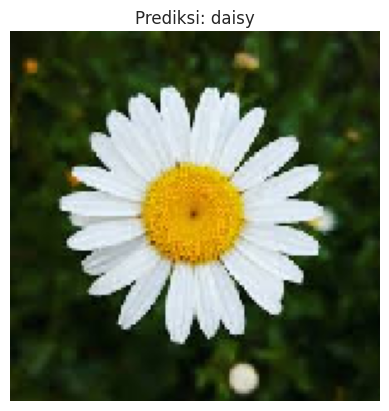

Probabilitas tiap kelas:
daisy: 100.00%
dandelion: 0.00%
rose: 0.00%
sunflower: 0.00%
tulip: 0.00%


In [ ]:
from google.colab import files

uploaded = files.upload()

img_path = list(uploaded.keys())[0]

# Load & preprocessing
img = keras_image.load_img(img_path, target_size=(150,150))
img_array = keras_image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Prediksi
pred = model_1.predict(img_array)
pred_class = np.argmax(pred)

# Ambil nama kelas
class_names = list(train_generator.class_indices.keys())

# Tampilkan hasil
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediksi: {class_names[pred_class]}")
plt.show()

print("Probabilitas tiap kelas:")
for i, cls in enumerate(class_names):
    print(f"{cls}: {pred[0][i]*100:.2f}%")

Saving closeup-shot-red-rose-with-dew-top-black_181624-28079.avif to closeup-shot-red-rose-with-dew-top-black_181624-28079.avif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


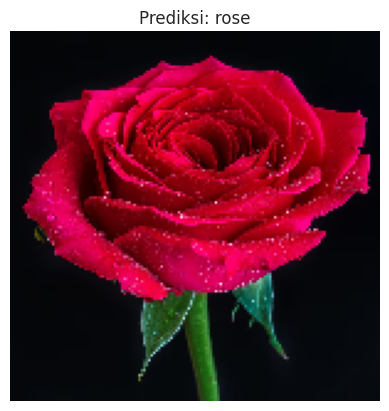

Probabilitas tiap kelas:
daisy: 0.00%
dandelion: 0.00%
rose: 100.00%
sunflower: 0.00%
tulip: 0.00%


In [ ]:
from google.colab import files

uploaded = files.upload()

img_path = list(uploaded.keys())[0]

# Load & preprocessing
img = keras_image.load_img(img_path, target_size=(150,150))
img_array = keras_image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Prediksi
pred = model_1.predict(img_array)
pred_class = np.argmax(pred)

# Ambil nama kelas
class_names = list(train_generator.class_indices.keys())

# Tampilkan hasil
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediksi: {class_names[pred_class]}")
plt.show()

print("Probabilitas tiap kelas:")
for i, cls in enumerate(class_names):
    print(f"{cls}: {pred[0][i]*100:.2f}%")

In [ ]:
!pip freeze > requirements.txt